In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from image_extractor import DataSetup
data = DataSetup()

OS: Windows
0 :  overall_geometry
1 :  overall_rgb
2 :  overall_hsv
3 :  color_grid
4 :  glcm_grid
5 :  comp_hsv
6 :  lbp_hist
7 :  haralick
8 :  red_haralick
9 :  blue_haralick


In [2]:
data.concat(dataID=[0, 3, 4, 5, 6, 7])
model_dir = 'D:./TF_backup/mlp/' + data.model_name
checkpoint_dir = 'D:./TF_checkpoint/mlp/weight/'
print(model_dir)

input_shape = (data.length,)
batch_size = 8

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

x_test size: (1260, 571)
x_train size: (7140, 571)
y_test size: (1260, 14)
y_train size: (7140, 14)
Model name = ' overall_geometry_color_grid_glcm_grid_comp_hsv_lbp_hist_haralick.h5 '
D:./TF_backup/mlp/overall_geometry_color_grid_glcm_grid_comp_hsv_lbp_hist_haralick.h5


In [3]:
normalizer = layers.Normalization()
normalizer.adapt(data.x_train)

# Define model
input_layer = layers.Input(shape=input_shape)
norm = normalizer(input_layer)
den1 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(norm)
drop1 = layers.Dropout(0.2)(den1)
den2 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(drop1)
drop2 = layers.Dropout(0.2)(den2)
den3 = layers.Dense(512, activation='relu', kernel_initializer='HeNormal')(drop2)
drop3 = layers.Dropout(0.2)(den3)
den4 = layers.Dense(512, activation='relu', kernel_initializer='HeNormal')(drop3)
drop4 = layers.Dropout(0.2)(den4)
den5 = layers.Dense(14, activation='softmax')(drop4)
model = keras.Model(input_layer, den5)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.4,
    nesterov=True,
    name='SGD',
)

model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

# model = keras.models.load_model(model_dir)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 571)]             0         
                                                                 
 normalization (Normalizatio  (None, 571)              1143      
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              585728    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

In [5]:
epochs = 10
model.fit(data.x_train, data.y_train, batch_size=8, shuffle=True, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/10
893/893 [==============================] - 6s 6ms/step - loss: 3.1964 - accuracy: 0.1088
Epoch 2/10
893/893 [==============================] - 5s 5ms/step - loss: 2.5717 - accuracy: 0.2071
Epoch 3/10
893/893 [==============================] - 5s 5ms/step - loss: 2.2343 - accuracy: 0.2832
Epoch 4/10
893/893 [==============================] - 5s 5ms/step - loss: 2.0521 - accuracy: 0.3354
Epoch 5/10
893/893 [==============================] - 5s 5ms/step - loss: 1.8964 - accuracy: 0.3818
Epoch 6/10
893/893 [==============================] - 5s 5ms/step - loss: 1.7533 - accuracy: 0.4203
Epoch 7/10
893/893 [==============================] - 5s 6ms/step - loss: 1.6559 - accuracy: 0.4525
Epoch 8/10
893/893 [==============================] - 5s 5ms/step - loss: 1.5576 - accuracy: 0.4810
Epoch 9/10
893/893 [==============================] - 5s 6ms/step - loss: 1.4659 - accuracy: 0.5050
Epoch 10/10
893/893 [==============================] - 5s 5ms/step - loss: 1.4225 - accuracy: 0.5099

In [12]:
epochs = 10
model.fit(data.x_train, data.y_train, batch_size=4, shuffle=True, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/10
1785/1785 [==============================] - 10s 5ms/step - loss: 0.8523 - accuracy: 0.7029
Epoch 2/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.8432 - accuracy: 0.6975
Epoch 3/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.7997 - accuracy: 0.7176
Epoch 4/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.7933 - accuracy: 0.7150
Epoch 5/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.7772 - accuracy: 0.7242
Epoch 6/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.7360 - accuracy: 0.7410
Epoch 7/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.7266 - accuracy: 0.7406
Epoch 8/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.7301 - accuracy: 0.7396
Epoch 9/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.6942 - accuracy: 0.7514
Epoch 10/10
1785/1785 [==============================] - 9s 5ms/step - loss: 0.68

In [17]:
score = model.evaluate(data.x_test, data.y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

40/40 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.7643
Test loss: 0.6588096022605896
Test accuracy: 0.7642857432365417


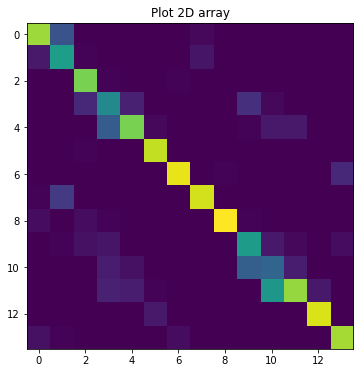

In [14]:
i = 0
cmatrix = np.zeros((14,14), dtype=np.int16)
bat = int(len(data.x_test)/60)
for i in range(0, len(data.x_test),bat):
    result = model.predict_on_batch(data.x_test[i:i+bat])
    ans = data.y_test[i:i+bat]
    for j in range(bat):
        id1 = np.argmax(result[j])
        id2 = np.argmax(ans[j])
        cmatrix[id1, id2] = cmatrix[id1][id2] + 1

cmatrix = np.absolute(cmatrix)
# print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

In [18]:
classes_name = ['Agglutinated', 'Brittle', 'Compartmentalized_Brown', 'Compartmentalized_PartiallyPurple', 'Compartmentalized_Purple', 'Compartmentalized_Slaty', 'Compartmentalized_White', 'Flattened', 'Moldered', 'Plated_Brown', 'Plated_PartiallyPurple', 'Plated_Purple', 'Plated_Slaty', 'Plated_White']
acc = []
for i in range(14):
    acc.append(np.round(cmatrix[i][i]/90,3))
    print(classes_name[i] + ': \t \t' + str(acc[i]))
print(np.mean(acc))

Agglutinated: 	 	0.844
Brittle: 	 	0.556
Compartmentalized_Brown: 	 	0.789
Compartmentalized_PartiallyPurple: 	 	0.467
Compartmentalized_Purple: 	 	0.789
Compartmentalized_Slaty: 	 	0.9
Compartmentalized_White: 	 	0.956
Flattened: 	 	0.922
Moldered: 	 	0.989
Plated_Brown: 	 	0.544
Plated_PartiallyPurple: 	 	0.322
Plated_Purple: 	 	0.833
Plated_Slaty: 	 	0.933
Plated_White: 	 	0.856
0.7642857142857142
